In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from random import shuffle
from random import seed
import category_encoders as ce
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
identity = pd.read_csv("train_identity.csv")
transaction = pd.read_csv("train_transaction.csv")
total_df = pd.merge(identity, transaction, how='right', on='TransactionID')

# Drop columns with missing values more than 60%

In [4]:
missing_most=total_df.columns[total_df.isnull().sum()/len(total_df)>0.6]

In [5]:
len(missing_most)

208

In [6]:
df=total_df.drop(missing_most,axis=1)

In [7]:
df.shape

(590540, 226)

Remove correlated

In [8]:
float_cols = np.where(df.dtypes == 'float64')
float_df = df.iloc[:, list(float_cols)[0]]
cor = float_df.corr() 
correlation_threshold = 0.95
corr = cor.copy()
corr.loc[:,:] =  np.tril(corr, k=-1)
already_in = set()
result = []
for col in corr:
    perfect_corr = corr[col][corr[col] > correlation_threshold].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)
drop = []
length = len(result)

In [9]:
uncorr_features = list(df.columns)
for i in range(length):
    for j in result[i][1:]:
        if j in uncorr_features:
            uncorr_features.remove(j)
        if j not in drop:
            drop.append(j)

In [10]:
len(uncorr_features)

166

In [11]:
len(drop)

60

In [12]:
df=df[uncorr_features]
df.shape

(590540, 166)

In [13]:
uncorr_features

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'P_emaildomain',
 'C2',
 'C3',
 'C5',
 'C9',
 'C13',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V11',
 'V12',
 'V13',
 'V14',
 'V16',
 'V18',
 'V19',
 'V20',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V28',
 'V30',
 'V32',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V49',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V58',
 'V60',
 'V61',
 'V62',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V70',
 'V72',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V81',
 'V82',
 'V83',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V91',
 'V93',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V104',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V11

# D features dive (TransactionDT based)

In this kernel we analyse the TransactionDT column, and support our hypothesis that the TransactionDT column starts at the 1st of December. We guess because the kaggle competition is released at sep. 2019

We can use the TransactionDT column to calculate features such as weekday and hour.

In [14]:
t_i = pd.read_csv("test_identity.csv")
t_t = pd.read_csv("test_transaction.csv")
test_df = pd.merge(t_i, t_t, how='right', on='TransactionID')

In [15]:
new_df=pd.concat([total_df,test_df],axis=0,sort=False)

In [16]:
len(new_df)

1097231

In [17]:
s=min(new_df['TransactionDT'])
e=max(new_df['TransactionDT'])
days=(e-s)/24/3600
months=days/30
print('days:',days)#almost 395 days!
print('months:',round(months))

days: 394.9993634259259
months: 13


The difference e-s = 34127945 but we don't know is it in seconds,minutes or hours at first.

If it is in hours then the dataset timespan will be (e-s)/24/365 = 3895.884132 years which is impossible.

if it is in minutes then the dataset timespan will be (e-s)/60/24/365 = 64.931402 years which is not possible because Vesta Corporation was founded in 1995.

If it is in seconds then dataset timespan will be (e-s)/(3600*24*365) = 1.0821 years which seems reasonable.

In [19]:
import datetime
START_DATE = '2017-12-01'
# Preprocess date column
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
new_time = new_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
print(new_time.head())
print(new_time.tail())

0   2017-12-02 00:01:46
1   2017-12-02 00:02:15
2   2017-12-02 00:02:29
3   2017-12-02 00:02:35
4   2017-12-02 00:03:40
Name: TransactionDT, dtype: datetime64[ns]
506686   2018-12-31 23:57:41
506687   2018-12-31 23:57:49
506688   2018-12-31 23:57:59
506689   2018-12-31 23:58:46
506690   2018-12-31 23:58:57
Name: TransactionDT, dtype: datetime64[ns]


In [20]:
time_df=pd.DataFrame()
time_df['time']=new_time
time_df['month'] = time_df['time'].apply(lambda x: x.month)
time_df['day'] = time_df['time'].apply(lambda x: x.day)
time_df['weekday'] = time_df['time'].apply(lambda x: x.weekday()+1)

In [21]:
time_df['hour'] = time_df['time'].apply(lambda x: x.hour)

In [22]:
n=len(df)
df['time']=time_df['time'][:n]
df['month']=time_df['month'][:n]
df['day']=time_df['day'][:n]
df['weekday']=time_df['weekday'][:n]
df['hour']=time_df['hour'][:n]

In [22]:
time_df['is_weekend']=time_df['weekday'].apply (lambda x: ((x==6)|(x==7))*1) #use x*1 to convert T/F to 1/0

In [200]:
df['is_december'] = df.month
df['is_december'] = (df['is_december']==12).astype(np.int8)

In [25]:
n=len(df)
fraud_index=np.where(df.isFraud==1)
nonfraud_index=np.where(df.isFraud==0)

In [169]:
import holidays
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays =holidays.US(years=[2017,2018])
df['is_holiday']=(df['time'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [199]:
us_holidays

{datetime.date(2017, 1, 1): "New Year's Day",
 datetime.date(2017, 1, 2): "New Year's Day (Observed)",
 datetime.date(2017, 1, 16): 'Martin Luther King Jr. Day',
 datetime.date(2017, 2, 20): "Washington's Birthday",
 datetime.date(2017, 5, 29): 'Memorial Day',
 datetime.date(2017, 7, 4): 'Independence Day',
 datetime.date(2017, 9, 4): 'Labor Day',
 datetime.date(2017, 10, 9): 'Columbus Day',
 datetime.date(2017, 11, 11): 'Veterans Day',
 datetime.date(2017, 11, 10): 'Veterans Day (Observed)',
 datetime.date(2017, 11, 23): 'Thanksgiving',
 datetime.date(2017, 12, 25): 'Christmas Day',
 datetime.date(2018, 1, 1): "New Year's Day",
 datetime.date(2018, 1, 15): 'Martin Luther King Jr. Day',
 datetime.date(2018, 2, 19): "Washington's Birthday",
 datetime.date(2018, 5, 28): 'Memorial Day',
 datetime.date(2018, 7, 4): 'Independence Day',
 datetime.date(2018, 9, 3): 'Labor Day',
 datetime.date(2018, 10, 8): 'Columbus Day',
 datetime.date(2018, 11, 11): 'Veterans Day',
 datetime.date(2018, 11, 

In [193]:
t1=np.sum(df.loc[fraud_index]['is_holiday'])/len(list(fraud_index)[0])
t2=np.sum(df.loc[nonfraud_index]['is_holiday'])/len(list(nonfraud_index)[0])
print('Holiday proportion of fraud dates:',t1)
print('Holiday proportion of non-fraud dates:',t2)

Holiday proportion of fraud dates: 0.023181532207327108
Holiday proportion of non-fraud dates: 0.026567136417156686


In [201]:
t1=np.sum(df.loc[fraud_index]['is_december'])/len(list(fraud_index)[0])
t2=np.sum(df.loc[nonfraud_index]['is_december'])/len(list(nonfraud_index)[0])
print('December proportion of fraud dates:',t1)
print('December proportion of non-fraud dates:',t2)

December proportion of fraud dates: 0.16459371824033298
December proportion of non-fraud dates: 0.22976537042203843


Holiday&December may not be an important feature of fraud transactions...

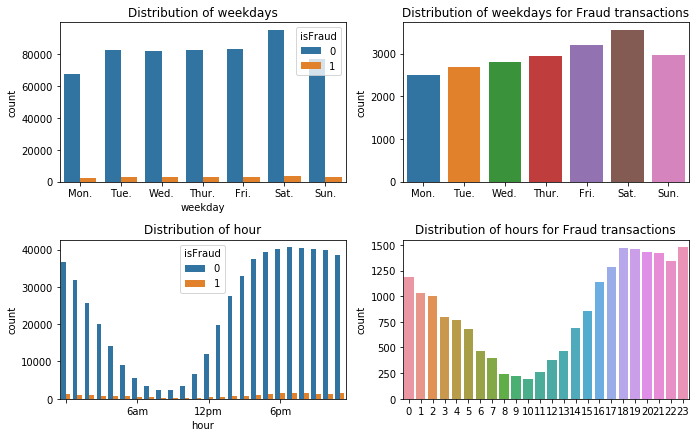

In [26]:
import seaborn as sns
fig=plt.figure(figsize=(10,6.18))
ax1=fig.add_subplot(2,2,1)
sns.countplot(x='weekday', data=df,hue='isFraud')
ax1.set_title('Distribution of weekdays')
ax1.set_xticks(np.arange(7))
ax1.set_xticklabels(('Mon.','Tue.','Wed.','Thur.','Fri.','Sat.','Sun.'))

ax2=fig.add_subplot(2,2,2)
temp1=np.array(time_df['weekday'])[fraud_index]
sns.countplot(temp1)
ax2.set_title('Distribution of weekdays for Fraud transactions')
ax2.set_xticks(np.arange(7))
ax2.set_xticklabels(['Mon.','Tue.','Wed.','Thur.','Fri.','Sat.','Sun.'])

ax3=fig.add_subplot(2,2,3)
sns.countplot(x='hour', data=df,hue='isFraud')
ax3.set_title('Distribution of hour')
ax3.set_xticks(np.arange(0,24,6))
ax3.set_xticklabels(['','6am','12pm','6pm'])

ax4=fig.add_subplot(2,2,4)
temp1=np.array(time_df['hour'])[fraud_index]
sns.countplot(temp1)
ax4.set_title('Distribution of hours for Fraud transactions')
#ax4.set_xticks(np.arange(24))
#ax4.set_xticklabels(['Mon.','Tue.','Wed.','Thur.','Fri.','Sat.','Sun.'])

plt.tight_layout()
plt.show()


In [27]:
a=df['hour'].value_counts()
b=pd.Series(temp1).value_counts()
c=[0]*24
for i in range(24):
    c[i]=b[i]/a[i]

# Plot hour-based fraud proportion of all transactions

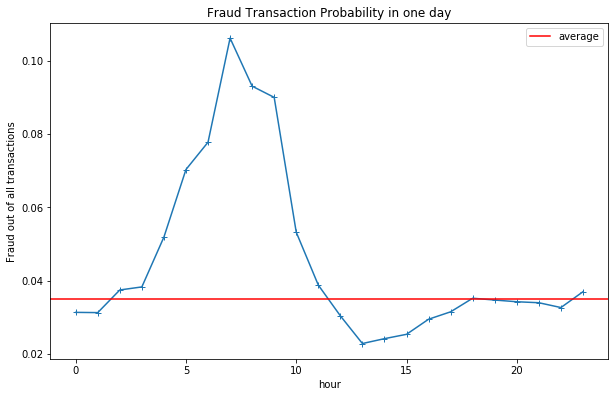

In [28]:
plt.figure(figsize=(10,6.18))
plt.plot(c,'+-')
plt.xlabel('hour')
plt.ylabel('Fraud out of all transactions')
plt.title('Fraud Transaction Probability in one day')
plt.axhline(y=sum(b)/sum(a),c="r",label='average')
plt.legend()
plt.show()

At 7am, fraud reaches peak! The peak is from am to 6am to 9am. After 10pm, when people start working, it goes back to normal.
There can be many reasons for that. 1)Oversea criminals, based on some personal experience :) 
2)The bank staff didn't start working at that time, and people cannot be reminded when they sleep...

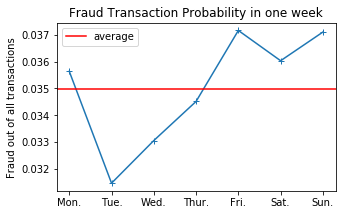

In [29]:
a=df['weekday'].value_counts()
b=pd.Series(np.array(time_df['weekday'])[fraud_index]).value_counts()
c=[0]*7
for i in range(7):
    c[i]=b[i+1]/a[i+1]
    
plt.figure(figsize=(5,3.09))
plt.plot(c,'+-')
plt.xticks(np.arange(0,7),labels=['Mon.','Tue.','Wed.','Thur.','Fri.','Sat.','Sun.'])
plt.ylabel('Fraud out of all transactions')
plt.title('Fraud Transaction Probability in one week')
plt.axhline(y=sum(b)/sum(a),c="r",label='average')
plt.legend()
plt.show()

From Fri. to Sun., number of fraud detetcion is increasing and it reaches bottom on Tue.

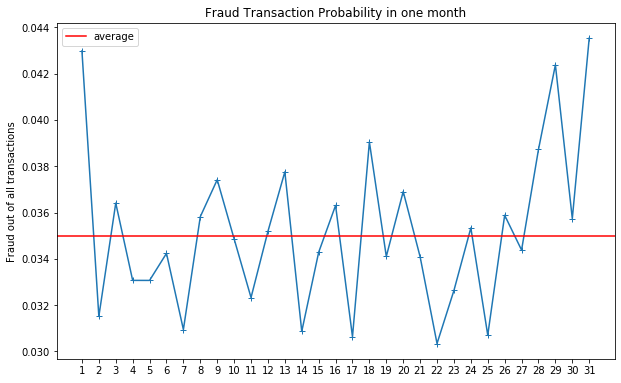

In [159]:
a=df['day'].value_counts()
b=pd.Series(np.array(time_df['day'])[fraud_index]).value_counts()
c=[0]*31
for i in range(31):
    c[i]=b[i+1]/a[i+1]
    
plt.figure(figsize=(10,6.18))
plt.plot(c,'+-')
plt.xticks(np.arange(0,31),labels=list(range(1,32)))
plt.ylabel('Fraud out of all transactions')
plt.title('Fraud Transaction Probability in one month')
plt.axhline(y=sum(b)/sum(a),c="r",label='average')
plt.legend()
plt.show()

29th,31st,1st are more likely to be fraud...why?

Overall, it seems fraud is more likely to happen out of normal working time.
Maybe it's part-time criminals hehe

In [35]:
temp=df[['month','hour','day','weekday','D2','D3','D5','D4','D10','D11','D15']] 
cor1=temp.corr()

Text(0.5, 1, 'correlation matrix of date-related features')

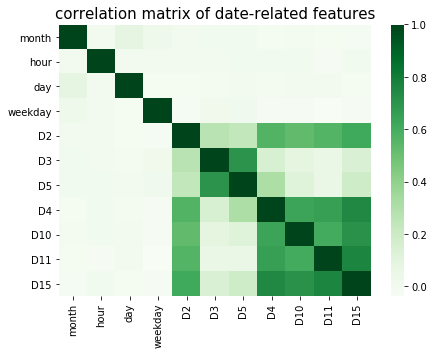

In [40]:
fig=plt.figure(figsize=(7,5))
sns.heatmap(cor1,cmap='Greens')
plt.title('correlation matrix of date-related features',fontsize=15)

D1 = 0 for most isFraud=1 transactions. Presumably this is due to a new card getting intercepted in the post, or a fraudster managing to request a card i somebody else's name.

D2: first transaction on the card. this appears to be the same as D1, except D1 = 0 values have been replaced by NaN.

D3: timedelta since the previous transaction for one card. As with D1 and D2, the this feature appears to count different cards separately.

D4: timedelta since first transaction for all cards on the account. Using the example of a husband and wife each using their own card on a joint credit card account, this feature would not distinguish between which card was used.

D5: timedelta since the previous transaction for all cards on the account.

In [295]:
df['D2']=total_df['D2']
df['D1']=total_df['D1']

In [307]:
#Calculate the number of transactions in natural hours and days
df['day_count'] = df.groupby(df.time.dt.date)['TransactionID'].transform('count')
df['hour_count'] = df.groupby(df.time.map(lambda x:str(x)[:13]))['TransactionID'].transform('count')

# TransactionAMT is the second most important feature in priliminary model

In [146]:
df['log_amt']=np.log(df['TransactionAmt'])
#Use decimal part of transaction amt as a new feature
df['decimal_amt']=df['TransactionAmt'].apply(lambda x: (x-int(x))*1000)

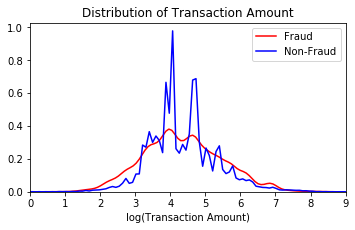

In [185]:
fig=plt.figure(figsize=(5,3.09))
#ax1=fig.add_subplot(1,2,1)
temp=df.loc[fraud_index]['log_amt']
sns.distplot(temp,  color='r', label='Fraud', hist=False, rug=False)
#ax1.set_title('Distribution of log(Transaction Amount) in Fraud Transaction')
#ax2=fig.add_subplot(1,2,2)
temp=df.loc[nonfraud_index]['log_amt']
sns.distplot(temp,color='b',label='Non-Fraud', hist=False, rug=False)
#ax2.set_title('Distribution of log(Transaction Amount) in Non-Fraud Transaction')
plt.tight_layout()
plt.xlim(0,9)
plt.xlabel('log(Transaction Amount)')
plt.title('Distribution of Transaction Amount')
plt.legend()
plt.show()

From the plot, fraud detection has a more normal-like shape, and it seems more frequent in small amount(e^3) or large amount(e^6)

#  Card Features Dive

In [66]:
by = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
grouped = df.groupby(by, as_index=False)['TransactionID'].count()

In [73]:
grouped.shape

(13691, 7)

In [250]:
temp.values.shape

(590540,)

In [296]:

df['DT_D'] = ((df['time'].dt.year-2017)*365 + df['time'].dt.dayofyear).astype(np.int16)
df['DT_W'] = (df['time'].dt.year-2017)*52 + df['time'].dt.weekofyear
df['DT_M'] = (df['time'].dt.year-2017)*12 + df['time'].dt.month

df['open_card'] = df.DT_D - total_df.D1
df['first_tran'] = df.DT_D - total_df.D2


In [297]:
#Use the six card features plus card-open-time(D1)&first-transaction-time(D2) as one card-id
df['card_id'] = df.card1.astype(str) +' '+ df.card2.astype(str)+' '+ df.card3.astype(str)+' '+df.card4.astype(str)+' '+ df.card5.astype(str)+' '+ df.card6.astype(str) +' '+ df.open_card.astype(str)+' '+ df.first_tran.astype(str)

In [298]:
df['card_id'].nunique()

189905

# Device Feature Clean

In [111]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    
    dn=['Samsung','Motorola','LG','RV','Huawei','ZTE','Linux','Sony','HTC','Asus']
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = dn[0]
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = dn[0]
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = dn[0]
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = dn[1]
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = dn[1]
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = dn[1]
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = dn[2]
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = dn[3]
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = dn[4]
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = dn[4]
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = dn[5]
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = dn[5]
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = dn[6]
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = dn[7]
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = dn[8]
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = dn[9]
    dataframe['device_name'].apply(lambda x: "Others" if (type(x)=='str') and (x not in dn) else x)
    
    return dataframe,id_list


In [123]:
temp=id_split(total_df)

In [124]:
df['device_name']=temp['device_name']
df['device_version']=temp['device_version']
df['OS_id_30']=temp['OS_id_30']
df['browser_id_31']=temp['browser_id_31']
df['device_version']=temp['device_version']
df['device_version']=temp['device_version']

In [270]:
#Identify a device using id_30, id_31, id_32, id_33, DeviceType, DeviceInfo

df['device_id'] = total_df.apply(lambda x: str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo']),
                                 axis=0)

In [271]:
df['device_id'].nunique()

9815

In [273]:
df['device_id'].value_counts()

nannannannannannan                                            449680
nanchrome 63.0nannandesktopWindows                              6351
nanmobile safari genericnannanmobilenan                         4961
nanmobile safari 11.0nannanmobilenan                            3244
nanchrome 63.0nannandesktopnan                                  3136
                                                               ...  
nanchrome 63.0 for androidnannanmobileU                            1
nanchrome 49.0 for androidnannanmobileLG-H420 Build/LRX21Y         1
nanGeneric/Androidnannanmobilerv:60.0                              1
nanchrome 63.0 for androidnannanmobileSAMSUNG-SGH-I337             1
Windows 7seamonkey24.01440x900desktoprv:51.0                       1
Name: device_id, Length: 9815, dtype: int64

In [303]:
#Number of devices with the same user
concat_df = df[['card_id','device_id']]
tmp = concat_df.groupby('card_id')['device_id'].agg(['nunique'])
tmp_dic=tmp.to_dict()['nunique']

In [304]:
df['card_id_number_of_device'] = df.card_id.map(tmp_dic)

In [305]:
max(df['card_id_number_of_device'])#one card use at most 109 device......

109

In [291]:
tmp.iloc[144242,]

nunique    109
Name: 6019 583.0 150.0 visa 226.0 credit 360.0 nan, dtype: int64

# Product CD, big difference in distribution

In [134]:
s1=total_df.groupby(['ProductCD'], as_index=False)['isFraud'].agg(['sum'])
s2=total_df.ProductCD.value_counts()

In [142]:
print('Fraud rate when buying different product')
s=s1['sum']/s2
print(s)

Fraud rate when buying different product
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
dtype: float64


Product Type C shows a high risk of fraud.

In [390]:
temp_dic=df.groupby(['ProductCD'], as_index=False)['log_amt'].agg(['mean'])['mean'].to_dict()

In [392]:
df['ProductCD_amt']=df['ProductCD'].apply(lambda x: temp_dic[x])

# P_domain feature clean

In [204]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple','uknown':'uknown'}

df['P_emaildomain'] = df['P_emaildomain'].fillna('uknown')
df['P_emaildomain_bin'] = df['P_emaildomain'].map(emails)
df['P_emaildomain_suffix']=df['P_emaildomain'].apply(lambda x: str(x).split('.')[-1])
df['P_emaildomain_prefix']=df['P_emaildomain'].apply(lambda x: str(x).split('.')[0])



In [205]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,device_version,OS_id_30,browser_id_31,log_amt,decimal_amt,is_holiday,is_december,P_emaildomain_bin,P_emaildomain_suffix,P_emaildomain_prefix
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,NRD90M,Android,samsung,3.912023,0.0,0,1,google,com,gmail
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,None,iOS,mobile,2.708050,0.0,0,1,other,com,anonymous
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,None,NaN,chrome,4.329245,887.0,0,1,google,com,gmail
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,NaN,NaN,chrome,2.803057,495.0,0,1,microsoft,com,hotmail
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,None,Mac,chrome,3.401197,0.0,0,1,aol,com,aol


# V features reduce dimension

In [345]:
dropV=drop[10:]
v_cols = ['V'+str(i) for i in range(1,340)]
v_remain=[elem for elem in v_cols if elem in list(df) ] 

In [347]:
#Dealing with V cols

from sklearn.preprocessing import StandardScaler
for col in test_group:
    sc = StandardScaler()
    sc.fit(df[[col]].fillna(0))
    df[col] = sc.transform(df[[col]].fillna(0))
    df[col] = sc.transform(df[[col]].fillna(0))
    




In [367]:
from sklearn.decomposition import PCA
#PCA
pca = PCA(random_state=2020,n_components=3)
pca.fit(df[test_group])
print(len(test_group), pca.transform(df[test_group]).shape[-1])

sc_variance =pca.explained_variance_ratio_
print(sc_variance)


130 3
[0.79755425 0.07329905 0.0578448 ]


In [368]:
temp=pca.transform(df[test_group])
for i in range(temp.shape[1]):
    df['V_pca_'+str(i)]=temp[:,i]

In [397]:
df.drop(test_group,axis=1,inplace=True)

In [398]:
list(df)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'P_emaildomain',
 'C2',
 'C3',
 'C5',
 'C9',
 'C13',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'time',
 'month',
 'day',
 'weekday',
 'hour',
 'device_name',
 'device_version',
 'OS_id_30',
 'browser_id_31',
 'log_amt',
 'decimal_amt',
 'is_holiday',
 'is_december',
 'P_emaildomain_bin',
 'P_emaildomain_suffix',
 'P_emaildomain_prefix',
 'card_id',
 'open_card',
 'first_tran',
 'D1',
 'DT_D',
 'DT_W',
 'DT_M',
 'device_id',
 'D2',
 'card_id_number_of_device',
 'day_count',
 'hour_count',
 'V_pca_0',
 'V_pca_1',
 'V_pca_2',
 'ProductCD_amt']

# Categorical Encoding

In [403]:
df.columns[np.where(df.dtypes=='object')]

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'device_name', 'device_version',
       'OS_id_30', 'browser_id_31', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'P_emaildomain_prefix', 'card_id', 'device_id'],
      dtype='object')

In [592]:
#encode by frequency, do not use target encode which may lead to overfit
from category_encoders import TargetEncoder
def ce(df,col):
    n=df.shape[0]
    for i in col:
        encoder = TargetEncoder()
        df[i+'_Encoded'] = encoder.fit_transform(df[i], df['isFraud'])
    return df

In [593]:
col=list(df.columns[np.where(df.dtypes=='object')])
df=ce(df,col)

In [594]:
df.iloc[:5,-len(col):]

,ProductCD_Encoded,card4_Encoded,card6_Encoded,P_emaildomain_Encoded,M1_Encoded,M2_Encoded,M3_Encoded,M4_Encoded,M5_Encoded,M6_Encoded,...,M9_Encoded,device_name_Encoded,device_version_Encoded,OS_id_30_Encoded,browser_id_31_Encoded,P_emaildomain_bin_Encoded,P_emaildomain_suffix_Encoded,P_emaildomain_prefix_Encoded,card_id_Encoded,device_id_Encoded
0,0.047662,0.034331,0.066785,0.043542,0.03499,0.03499,0.03499,0.034990,0.03499,0.03499,...,0.03499,0.115944,0.096141,0.085991,0.087084,0.043496,0.037005,0.043496,3.499001e-02,1.173390e-05
1,0.047662,0.034756,0.024263,0.023217,0.03499,0.03499,0.03499,0.034990,0.03499,0.03499,...,0.03499,0.062683,0.034990,0.062683,0.075514,0.025914,0.037005,0.023217,1.320920e-12,2.954755e-02
2,0.116873,0.034331,0.066785,0.043542,0.03499,0.03499,0.03499,0.036649,0.03499,0.03499,...,0.03499,0.065400,0.034990,0.034990,0.095952,0.043496,0.037005,0.043496,1.659432e-03,8.298172e-02
3,0.116873,0.034331,0.024263,0.052950,0.03499,0.03499,0.03499,0.036649,0.03499,0.03499,...,0.03499,0.034990,0.034990,0.034990,0.095952,0.053298,0.037005,0.052516,2.909517e-08,1.158690e-01
4,0.047662,0.034756,0.024263,0.021811,0.03499,0.03499,0.03499,0.034990,0.03499,0.03499,...,0.03499,0.022111,0.034990,0.021944,0.095952,0.022969,0.037005,0.021811,3.499001e-02,4.859413e-13


In [441]:
b=df.nunique()
#No only one unique value in every column

In [451]:
df.columns[b==2]#binary cols

Index(['isFraud', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'is_holiday',
       'is_december'],
      dtype='object')

In [464]:
#From the distribution, these m features should be some new deatures implemented during the time span of the dataset
m=['M1', 'M2', 'M3','M4' ,'M5', 'M6', 'M7', 'M8', 'M9']

In [479]:
df[m].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None
2,None,None,None,M0,None,None,None,None,None
3,None,None,None,M0,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None


In [480]:
df[m].tail()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,None,None,T,None,None,None
590538,T,T,T,M0,F,T,None,None,None
590539,T,F,F,None,None,T,F,F,F


# Lgbm Model

In [600]:
choose_features=df.columns[-len(col):]

In [607]:
choose_features=list(choose_features)+['TransactionDT', 'TransactionAmt', 'C2', 'C3', 'C5', 'C9', 'C13','D1','D2' ,'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'month', 'day', 'weekday', 'hour','log_amt', 'decimal_amt', 'is_holiday', 'is_december','card_id_number_of_device', 'day_count', 'hour_count', 'V_pca_0',
       'V_pca_1', 'V_pca_2', 'ProductCD_amt']
#choose_features=choose_features.remove('isFraud')

In [608]:
choose_features

['ProductCD_Encoded',
 'card4_Encoded',
 'card6_Encoded',
 'P_emaildomain_Encoded',
 'M1_Encoded',
 'M2_Encoded',
 'M3_Encoded',
 'M4_Encoded',
 'M5_Encoded',
 'M6_Encoded',
 'M7_Encoded',
 'M8_Encoded',
 'M9_Encoded',
 'device_name_Encoded',
 'device_version_Encoded',
 'OS_id_30_Encoded',
 'browser_id_31_Encoded',
 'P_emaildomain_bin_Encoded',
 'P_emaildomain_suffix_Encoded',
 'P_emaildomain_prefix_Encoded',
 'card_id_Encoded',
 'device_id_Encoded',
 'TransactionDT',
 'TransactionAmt',
 'C2',
 'C3',
 'C5',
 'C9',
 'C13',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'month',
 'day',
 'weekday',
 'hour',
 'log_amt',
 'decimal_amt',
 'is_holiday',
 'is_december',
 'card_id_number_of_device',
 'day_count',
 'hour_count',
 'V_pca_0',
 'V_pca_1',
 'V_pca_2',
 'ProductCD_amt']

## Unbalanced
### Undersample majority class & oversampling minority class

In [637]:
len(nonfraud_index[0])/len(fraud_index[0])

27.579586700866283

So upsample fraud to 10 times, downsample nonfraud to same amount.

In [796]:
# upsample minority
np.random.seed(2020)
nonfraud_downsampled = np.random.choice(nonfraud_index[0],
                          replace=False, 
                          size=len(fraud_index[0])) # reproducible results


In [798]:
# combine majority and upsampled minority
sampled_index=np.hstack((nonfraud_downsampled,fraud_index[0]))

## Set aside 20% for validation

In [799]:
n=len(sampled_index)
np.random.shuffle(sampled_index)
train_index=sampled_index[:int(0.8*n)]
val_index=sampled_index[int(0.8*n):]

In [800]:
n

41326

In [801]:
train_x=df[choose_features].loc[train_index]
train_y=df['isFraud'].loc[train_index]

In [802]:
val_x=df[choose_features].loc[val_index]
val_y=df['isFraud'].loc[val_index]

In [803]:
np.sum(val_y)/len(val_y)

0.5033873699491894

In [804]:
np.sum(train_y)/len(train_y)

0.49915305505142166

In [805]:
params={ 
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'n_jobs':-1,
    'learning_rate':0.01,
    'num_leaves': 2**8,
    'max_depth':-1,
    'n_estimators':20000,
    'verbose':-1,
    'seed': 2020,
    'early_stopping_rounds':100, 
}


gbm = lgb.LGBMClassifier(**params)
gbm.fit(train_x, train_y,
        eval_set = [(val_x, val_y)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 100, verbose = -1)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[566]	valid_0's binary_logloss: 0.113422	valid_0's auc: 0.992637


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               early_stopping_rounds=100, importance_type='split',
               learning_rate=0.01, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20000, n_jobs=-1, num_leaves=256,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=2020, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [806]:
pred = gbm.predict(val_x)

In [807]:
pd.DataFrame(pred).to_csv('pred_1.csv')

In [808]:
print('AUC:', metrics.roc_auc_score(val_y, pred))
print('Confusion matrix:')
print(metrics.confusion_matrix(val_y, pred))
print(metrics.classification_report(val_y, pred))

AUC: 0.9527739894344005
Confusion matrix:
[[3884  221]
 [ 169 3992]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4105
           1       0.95      0.96      0.95      4161

    accuracy                           0.95      8266
   macro avg       0.95      0.95      0.95      8266
weighted avg       0.95      0.95      0.95      8266



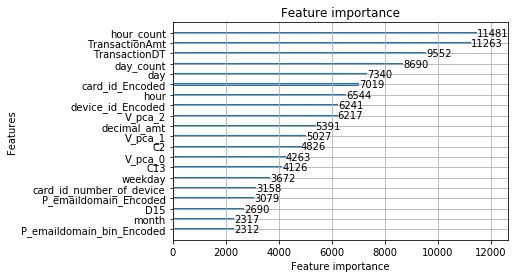

In [809]:
lgb.plot_importance(gbm,max_num_features=20)

In [759]:
top10_features=['hour_count','TransactionAmt','TransactionDT','day_count','day','card_id_Encoded','hour','device_id_Encoded','V_pca_2','decimal_amt']

## fit model with top 10 features

In [810]:
params={ 
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'n_jobs':-1,
    'learning_rate':0.01,
    'num_leaves': 2**8,
    'max_depth':-1,
    'n_estimators':20000,
    'verbose':-1,
    'seed': 2020,
    'early_stopping_rounds':100, 
}

top10_features=['hour_count','TransactionAmt','TransactionDT','day_count',
          'day','card_id_Encoded','hour','device_id_Encoded','V_pca_2']
gbm2 = lgb.LGBMClassifier(**params)
gbm2.fit(train_x[top10_features], train_y,
        eval_set = [(val_x[top10_features], val_y)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 100, verbose = -1)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[498]	valid_0's binary_logloss: 0.139878	valid_0's auc: 0.988371


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               early_stopping_rounds=100, importance_type='split',
               learning_rate=0.01, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20000, n_jobs=-1, num_leaves=256,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=2020, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [811]:
pred2 = gbm2.predict(val_x[top10_features])

In [812]:
print('AUC:', metrics.roc_auc_score(val_y, pred2))
print('Confusion matrix:')
print(metrics.confusion_matrix(val_y, pred2))
print(metrics.classification_report(val_y, pred2))

AUC: 0.9409356822721043
Confusion matrix:
[[3846  259]
 [ 229 3932]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4105
           1       0.94      0.94      0.94      4161

    accuracy                           0.94      8266
   macro avg       0.94      0.94      0.94      8266
weighted avg       0.94      0.94      0.94      8266



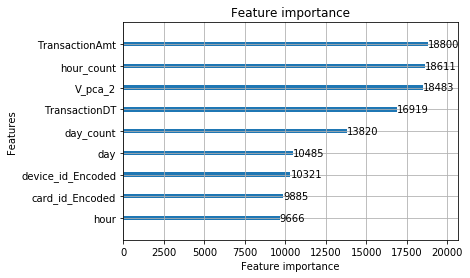

In [813]:
lgb.plot_importance(gbm2)

# fit top5 features

In [814]:
top5_features=['TransactionAmt','hour_count','V_pca_2','TransactionDT','day_count']
gbm3 = lgb.LGBMClassifier(**params)
gbm3.fit(train_x[top5_features], train_y,
        eval_set = [(val_x[top5_features], val_y)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 100, verbose = -1)
pred3 = gbm3.predict(val_x[top5_features])
print('AUC:', metrics.roc_auc_score(val_y, pred3))
print('Confusion matrix:')
print(metrics.confusion_matrix(val_y, pred3))
print(metrics.classification_report(val_y, pred3))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1067]	valid_0's binary_logloss: 0.524589	valid_0's auc: 0.815839
AUC: 0.7368092322977032
Confusion matrix:
[[3132  973]
 [1204 2957]]
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      4105
           1       0.75      0.71      0.73      4161

    accuracy                           0.74      8266
   macro avg       0.74      0.74      0.74      8266
weighted avg       0.74      0.74      0.74      8266



Bad Performace.

# Top 10 features analysis

In [816]:
top10_features

['hour_count',
 'TransactionAmt',
 'TransactionDT',
 'day_count',
 'day',
 'card_id_Encoded',
 'hour',
 'device_id_Encoded',
 'V_pca_2']

## 1.hour_count

In [831]:
temp=df.groupby('hour_count',as_index=False)['isFraud'].agg('sum')

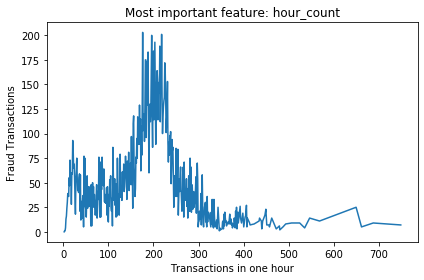

In [832]:
plt.plot(temp.hour_count,temp.isFraud)
plt.xlabel('Transactions in one hour')
plt.ylabel('Fraud Transactions')
plt.title('Most important feature: hour_count')
plt.tight_layout()

We can see when there are 200 transactions in one hour, surge

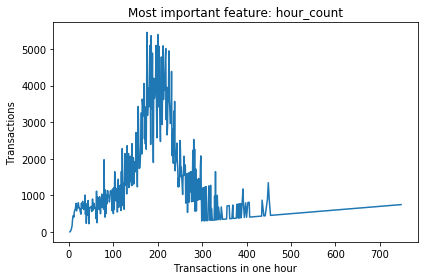

In [862]:
temp2=df.groupby('hour_count',as_index=False)['isFraud'].agg('count')
plt.plot(temp2.hour_count,temp2.isFraud)
plt.xlabel('Transactions in one hour')
plt.ylabel('Transactions')
plt.title('Most important feature: hour_count')
plt.tight_layout()

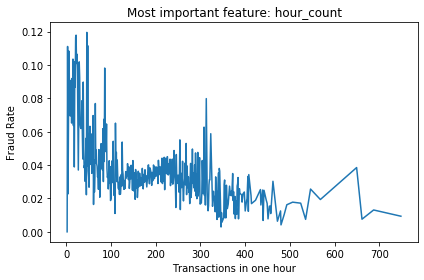

In [835]:
plt.plot(temp.hour_count,temp.isFraud/temp2.isFraud)
plt.xlabel('Transactions in one hour')
plt.ylabel('Fraud Rate')
plt.title('Most important feature: hour_count')
plt.tight_layout()

In [837]:
max(temp.isFraud/temp2.isFraud)

0.11956521739130435

In [839]:
np.where(temp.isFraud/temp2.isFraud==max(temp.isFraud/temp2.isFraud))

(array([44]),)

In [840]:
temp.hour_count[44]

46

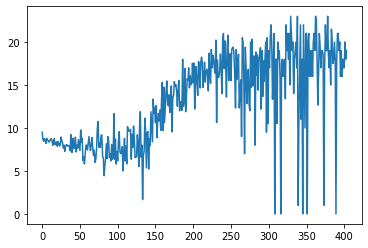

In [851]:
temp=df.groupby('hour_count',as_index=False)['hour'].agg('mean')['hour']
plt.plot(temp.index,temp.values)

In [850]:
temp=df[df['hour_count']==46]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,M9_Encoded,device_name_Encoded,device_version_Encoded,OS_id_30_Encoded,browser_id_31_Encoded,P_emaildomain_bin_Encoded,P_emaildomain_suffix_Encoded,P_emaildomain_prefix_Encoded,card_id_Encoded,device_id_Encoded
7861,3015475,0,713067,34.105,C,3867,296.0,185.0,visa,226.0,...,0.034990,0.065400,3.499001e-02,0.034990,0.078152,0.022052,0.023209,0.022544,1.659432e-03,0.043937
7862,3015477,0,713159,8.512,C,16136,204.0,185.0,visa,138.0,...,0.034990,0.132174,9.760353e-12,0.034990,0.095952,0.053298,0.037005,0.052516,2.341829e-04,0.004171
7863,3015479,0,713329,100.000,H,5714,170.0,150.0,visa,195.0,...,0.034990,0.062683,3.499001e-02,0.062683,0.075514,0.043496,0.037005,0.043496,9.410263e-03,0.022222
7864,3015481,0,713378,100.000,H,5714,170.0,150.0,visa,195.0,...,0.034990,0.062683,3.499001e-02,0.062683,0.075514,0.043496,0.037005,0.043496,9.410263e-03,0.022222
7865,3015483,0,713403,50.000,H,8406,264.0,150.0,visa,226.0,...,0.034990,0.022111,3.499001e-02,0.021944,0.027376,0.043496,0.037005,0.043496,4.170911e-03,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580837,3565741,0,15421899,49.000,W,15084,432.0,150.0,visa,226.0,...,0.017787,0.034990,3.499001e-02,0.034990,0.034990,0.029538,0.029538,0.029538,1.659432e-03,0.021006
580838,3565744,0,15422148,65.950,W,12544,321.0,150.0,visa,226.0,...,0.017787,0.034990,3.499001e-02,0.034990,0.034990,0.022052,0.037005,0.022544,1.173390e-05,0.021006
580839,3565746,0,15422158,59.000,W,14065,298.0,150.0,visa,195.0,...,0.017787,0.034990,3.499001e-02,0.034990,0.034990,0.025914,0.037005,0.023217,3.499001e-02,0.021006
580840,3565747,0,15422191,105.000,W,2884,490.0,150.0,visa,226.0,...,0.017787,0.034990,3.499001e-02,0.034990,0.034990,0.022969,0.037005,0.021811,1.070352e-08,0.021006


## 2.daycount

In [853]:
temp=df.groupby('day_count',as_index=False)['isFraud'].agg('sum')

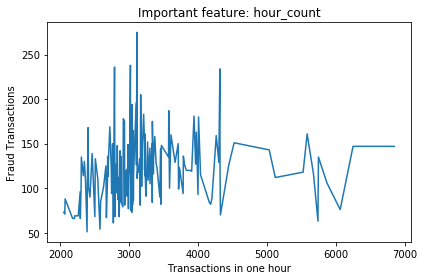

In [856]:
plt.plot(temp.day_count,temp.isFraud)
plt.xlabel('Transactions in one hour')
plt.ylabel('Fraud Transactions')
plt.title('Important feature: hour_count')
plt.tight_layout()

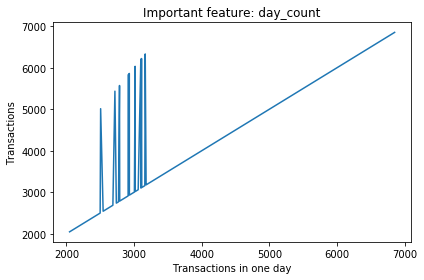

In [864]:
temp2=df.groupby('day_count',as_index=False)['isFraud'].agg('count')
plt.plot(temp2.day_count,temp2.isFraud)
plt.xlabel('Transactions in one day')
plt.ylabel('Transactions')
plt.title('Important feature: day_count')
plt.tight_layout()

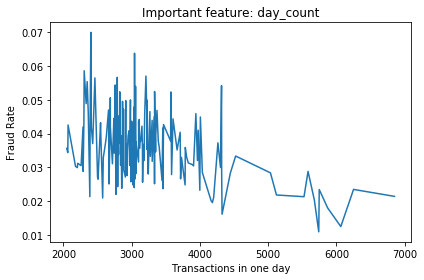

In [866]:
plt.plot(temp.day_count,temp.isFraud/temp2.isFraud)
plt.xlabel('Transactions in one day')
plt.ylabel('Fraud Rate')
plt.title('Important feature: day_count')
plt.tight_layout()

In [868]:
np.where(temp.isFraud/temp2.isFraud==max(temp.isFraud/temp2.isFraud))

(array([16]),)

In [869]:
temp.day_count[16]

2402

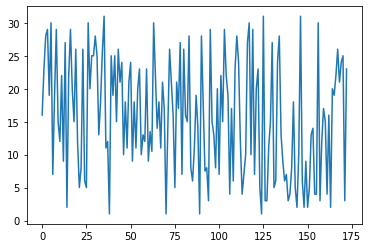

In [870]:
temp=df.groupby('day_count',as_index=False)['day'].agg('mean')['day']
plt.plot(temp.index,temp.values)

## 3.card_id_Encoded

In [877]:
temp=df['card_id'].value_counts()

In [880]:
temp[:20]

15775 481.0 150.0 mastercard 102.0 credit 464.0 464.0    1413
9500 321.0 150.0 visa 226.0 debit 250.0 250.0             479
7919 194.0 150.0 mastercard 166.0 debit 427.0 nan         259
12616 490.0 150.0 visa nan credit -156.0 nan              242
8900 385.0 150.0 visa 226.0 debit 275.0 275.0             231
8528 215.0 150.0 visa 226.0 debit 176.0 176.0             215
12741 106.0 150.0 visa 226.0 debit 133.0 133.0            196
7207 111.0 150.0 visa 226.0 debit -130.0 -130.0           192
7919 194.0 150.0 mastercard 166.0 debit 459.0 nan         174
7919 194.0 150.0 mastercard 166.0 debit 427.0 427.0       174
6019 583.0 150.0 visa 226.0 credit 360.0 nan              172
6019 583.0 150.0 visa 226.0 credit 359.0 nan              169
7919 194.0 150.0 mastercard 202.0 debit 398.0 nan         169
7919 194.0 150.0 mastercard 202.0 debit 369.0 nan         161
7919 194.0 150.0 mastercard 202.0 debit 399.0 nan         152
13597 198.0 150.0 visa 226.0 debit 287.0 287.0            147
7919 194

In [937]:
temp2=df.groupby('card_id')['isFraud'].agg('sum')

In [934]:
f_cardid=temp2[temp2>50]

In [915]:
zerofraud=np.sum(temp2==0)

In [916]:
zerofraud/len(temp2) #95.2% cards have no fraud record

0.9524973012822201

In [894]:
onefraud=zerofraud=np.sum(temp2==1)

In [895]:
onefraud/len(temp2)

0.02865116768910771

In [896]:
twofraud=zerofraud=np.sum(temp2==2)

In [898]:
twofraud/len(temp2)

0.008630631105026198

In [905]:
frefraud=np.sum(temp2>2)

In [906]:
frefraud/len(temp2)

0.010220899923646033

Text(0.5, 1.0, 'Important feature: card_id')

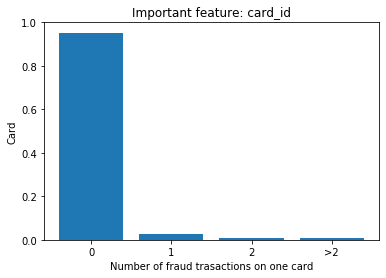

In [918]:
plt.bar([0,1,2,3],[zerofraud/len(temp2),onefraud/len(temp2),twofraud/len(temp2),frefraud/len(temp2)])
plt.xticks(np.arange(0,4),labels=['0','1','2','>2'])
plt.xlabel('Number of fraud trasactions on one card')
plt.ylabel('Card')
plt.title('Important feature: card_id')


Text(0.5, 1.0, 'Important feature: card_id')

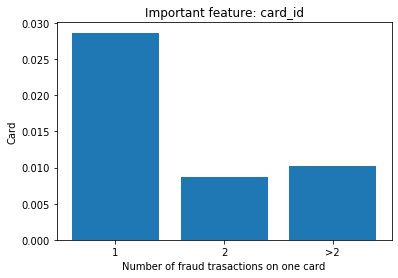

In [921]:
plt.bar([1,2,3],[onefraud/len(temp2),twofraud/len(temp2),frefraud/len(temp2)])
plt.xticks(np.arange(1,4),labels=['1','2','>2'])
plt.xlabel('Number of fraud trasactions on one card')
plt.ylabel('Card')
plt.title('Important feature: card_id')

## 4. device_id

In [922]:
temp=df['device_id'].value_counts()

In [940]:
temp[:10]

nannannannannannan                                  449680
nanchrome 63.0nannandesktopWindows                    6351
nanmobile safari genericnannanmobilenan               4961
nanmobile safari 11.0nannanmobilenan                  3244
nanchrome 63.0nannandesktopnan                        3136
nanchrome 64.0nannandesktopWindows                    2838
Windows 10chrome 63.024.01920x1080desktopWindows      2566
nanchrome 65.0nannandesktopWindows                    2523
nanchrome 66.0nannandesktopWindows                    1531
nanchrome 62.0nannandesktopWindows                    1422
Name: device_id, dtype: int64

In [925]:
temp2=df.groupby('card_id')['isFraud'].agg('sum')

In [928]:
n=len(temp2)
ln=[]
for i in range(4):
    ln.append(np.sum(temp2==i)/n)

In [931]:
ln=ln[:-1]
ln=ln+[1-np.sum(ln)]

Text(0.5, 1.0, 'Important feature: card_id')

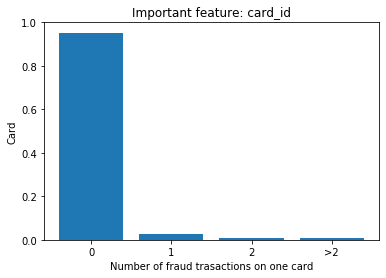

In [932]:
plt.bar([0,1,2,3],ln)
plt.xticks(np.arange(0,4),labels=['0','1','2','>2'])
plt.xlabel('Number of fraud trasactions on one device')
plt.ylabel('Device')
plt.title('Important feature: device_id')


Text(0.5, 1.0, 'Important feature: device_id')

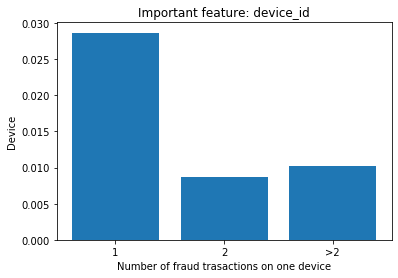

In [933]:
plt.bar([1,2,3],ln[1:])
plt.xticks(np.arange(1,4),labels=['1','2','>2'])
plt.xlabel('Number of fraud trasactions on one device')
plt.ylabel('Device')
plt.title('Important feature: device_id')